In [1]:
import timm
from fastai.vision.all import *

## Clear Cuda Memory

In [2]:
import gc
def clear():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

## Create pandas Dataframe

In [3]:
path = Path('/root/.fastai/data/oxford-iiit-pet')
Path.BASE_PATH = path

In [4]:
def create_pet_sample(frac:float, random_state:int=42):
    files = get_image_files(path/'images')
    lbl = RegexLabeller(r'(.+)_\d+.jpg')
    def parse(fn):
        return fn.name, lbl(fn.name)
    df = pd.DataFrame(data=files.map(parse), columns=['fname','label'])
    dff = df.groupby('label').apply(lambda x: x.sample(frac=frac, random_state=random_state)).reset_index(drop=True)
    dff.to_csv('pets_sample.csv', index=False)
    print(df.shape[0], dff.shape[0])

In [5]:
# create_pet_sample(.3)

In [6]:
df = pd.read_csv('pets_sample.csv')

def get_dls(item_tfms=Resize(380), 
            batch_tfms=aug_transforms(size=224), 
            valid_pct=.4):
    return ImageDataLoaders.from_df(df, path/'images',
                                    valid_pct=valid_pct,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms,
                                    seed=42)

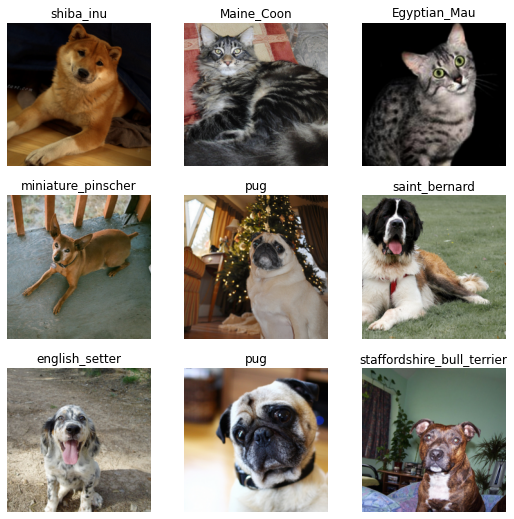

In [54]:
dls = get_dls()
dls.show_batch()

In [57]:
timm.list_models('*convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [59]:
arch = 'convnext_nano'
learn = vision_learner(dls, arch, metrics=error_rate)
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,5.172249,3.717405,0.945578,00:20
1,3.986923,1.819973,0.408163,00:19
2,2.820845,0.760770,0.231293,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.616803,0.593174,0.170068,00:40
1,0.561816,0.488886,0.156463,00:37
2,0.464276,0.418621,0.115646,00:38
3,0.412691,0.438361,0.129252,00:37
4,0.356561,0.465292,0.129252,00:37
5,0.311862,0.465664,0.122449,00:37
6,0.275358,0.448258,0.136054,00:37
7,0.238398,0.484317,0.136054,00:37
8,0.215805,0.450566,0.129252,00:37
9,0.187785,0.447609,0.129252,00:37


In [60]:
from fastai.callback.all import *

In [61]:
dls = get_dls()
learn = vision_learner(dls, arch, metrics=error_rate, cbs=CutMixUp(1.))
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,5.162472,3.460585,0.904762,00:19
1,4.566957,1.914132,0.387755,00:19
2,3.831041,0.828556,0.224490,00:19


epoch,train_loss,valid_loss,error_rate,time
0,2.545002,0.729397,0.231293,00:37
1,2.469459,0.670943,0.224490,00:37
2,2.386834,0.563924,0.156463,00:37
3,2.334829,0.538021,0.142857,00:36
4,2.274510,0.577193,0.183673,00:37
5,2.204131,0.533283,0.156463,00:37
6,2.151506,0.502334,0.149660,00:37
7,2.096709,0.473852,0.142857,00:36
8,2.070563,0.475972,0.149660,00:36
9,2.047322,0.471163,0.149660,00:37


In [62]:
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,1.935604,0.465528,0.163265,00:20


epoch,train_loss,valid_loss,error_rate,time
0,1.932847,0.467745,0.142857,00:36
1,1.924747,0.470004,0.136054,00:37
2,1.901077,0.463400,0.142857,00:36
3,1.897552,0.480246,0.136054,00:37
4,1.868448,0.542105,0.149660,00:37
5,1.845485,0.438808,0.129252,00:37
6,1.819831,0.434782,0.122449,00:36
7,1.803443,0.430035,0.136054,00:36
8,1.801500,0.420210,0.129252,00:37
9,1.791580,0.417109,0.129252,00:37


In [63]:
dls = get_dls()
learn = vision_learner(dls, arch, metrics=error_rate, cbs=CutMix(1.))
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,5.111431,3.445099,0.904762,00:19
1,4.531369,1.928717,0.360544,00:19
2,3.968435,0.906903,0.251701,00:19


/root/mambaforge/lib/python3.9/site-packages/fastai/callback/mixup.py:110: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = torch.clamp(cx - cut_w // 2, 0, W)
/root/mambaforge/lib/python3.9/site-packages/fastai/callback/mixup.py:111: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y1 = torch.clamp(cy - cut_h // 2, 0, H)
/root/mambafor

epoch,train_loss,valid_loss,error_rate,time
0,2.403354,0.771573,0.217687,00:36
1,2.324183,0.644930,0.170068,00:37
2,2.372923,0.555291,0.197279,00:36
3,2.283031,0.516565,0.176871,00:37
4,2.140772,0.465692,0.142857,00:36
5,2.008845,0.460492,0.142857,00:37
6,1.966898,0.489207,0.163265,00:36
7,1.920484,0.459771,0.149660,00:37
8,1.897835,0.442967,0.142857,00:36
9,1.889843,0.433532,0.129252,00:37


In [18]:
learn, dls = None, None
clear()

In [6]:
arch = 'convnext_tiny_in22k'
dls = get_dls()
learn = vision_learner(dls, arch, metrics=error_rate)
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,4.912163,3.584185,0.897959,00:27
1,3.654774,1.022772,0.285714,00:27
2,2.524674,0.412105,0.129252,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.366570,0.351902,0.122449,00:59
1,0.340493,0.321438,0.115646,00:57
2,0.309809,0.298415,0.088435,00:58
3,0.265015,0.282142,0.081633,00:57
4,0.235644,0.284050,0.081633,00:58
5,0.205252,0.288270,0.088435,00:57
6,0.179858,0.293258,0.102041,00:58
7,0.163105,0.253933,0.081633,00:57
8,0.140621,0.275675,0.088435,00:58
9,0.123926,0.284354,0.095238,00:57


In [7]:
learn.fit_one_cycle(10, lr_max=(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.070508,0.280185,0.095238,00:58
1,0.061099,0.275371,0.088435,00:57
2,0.056127,0.272386,0.095238,00:58
3,0.055822,0.267724,0.088435,00:57
4,0.053426,0.264739,0.081633,00:58
5,0.052122,0.264774,0.074830,00:58
6,0.051107,0.261897,0.074830,00:58
7,0.049957,0.261845,0.074830,00:57
8,0.048523,0.263684,0.068027,00:58
9,0.051016,0.265399,0.068027,00:58


In [8]:
learn.fit_one_cycle(10, lr_max=(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.047646,0.264402,0.068027,00:58
1,0.044896,0.262465,0.074830,00:57
2,0.047754,0.259947,0.081633,00:58
3,0.044928,0.262079,0.068027,00:58
4,0.042529,0.263633,0.074830,00:58
5,0.046256,0.260242,0.068027,00:58
6,0.044510,0.265240,0.074830,00:58
7,0.043970,0.264505,0.068027,00:58
8,0.041947,0.263178,0.068027,00:58
9,0.042354,0.260976,0.068027,00:57


In [41]:
learn = None
dls = None
clear()

In [40]:
dls = get_dls()
learn = vision_learner(dls, arch, metrics=error_rate)
learn.path = Path('.')

SuggestedLRs(valley=0.0010000000474974513)

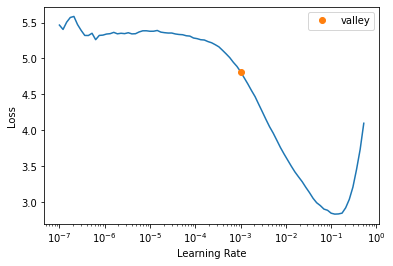

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(6, lr_max=.01)

epoch,train_loss,valid_loss,error_rate,time
0,2.165021,0.468367,0.145598,01:09
1,1.148803,0.564925,0.146727,01:08
2,0.808800,0.456814,0.118510,01:09
3,0.603530,0.441064,0.111738,01:08
4,0.424778,0.283446,0.080135,01:09
5,0.312305,0.271419,0.077878,01:09


In [43]:
learn.export('convnext_nano_380_224_stage_0.pth')

learn = load_learner('convnext_nano_380_224_stage_0.pth')
learn.dls = get_dls()
learn.unfreeze()

In [44]:
learn.fit_one_cycle(16, lr_max=(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.112005,0.266454,0.079007,02:17
1,0.091661,0.265155,0.074492,02:17
2,0.094968,0.255486,0.077878,02:17
3,0.091199,0.251713,0.077878,02:17
4,0.085269,0.250236,0.074492,02:17
5,0.085405,0.246327,0.075621,02:17
6,0.082117,0.241738,0.074492,02:16
7,0.075780,0.236867,0.075621,02:17
8,0.078345,0.234048,0.072235,02:17
9,0.074086,0.232836,0.071106,02:17


In [45]:
learn.export('convnext_nano_380_224_stage_1.pth')

In [5]:
learn = None
dls = None
clear()
learn = load_learner('convnext_nano_380_224_stage_1.pth')
learn.dls = get_dls()
learn.unfreeze()

In [6]:
learn.fit_one_cycle(16, lr_max=(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.056751,0.229881,0.071106,02:18
1,0.068738,0.231158,0.069977,02:16
2,0.063639,0.226694,0.068849,02:16
3,0.059841,0.227875,0.073363,02:17
4,0.058532,0.225374,0.072235,02:16
5,0.058138,0.225774,0.071106,02:17
6,0.059041,0.222144,0.068849,02:17
7,0.059715,0.222299,0.068849,02:17
8,0.055340,0.221653,0.067720,02:17
9,0.054885,0.222738,0.066591,02:19


In [7]:
learn = None
dls = None
clear()
learn = load_learner('convnext_nano_380_224_stage_0.pth')
learn.dls = get_dls()
learn.unfreeze()

In [8]:
learn.fit_one_cycle(16, lr_max=(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.120231,0.259285,0.077878,02:18
1,0.095421,0.248814,0.074492,02:17
2,0.079888,0.251202,0.075621,02:18
3,0.071546,0.221244,0.071106,02:17
4,0.065009,0.246864,0.076749,02:18
5,0.067782,0.243309,0.079007,02:18
6,0.060615,0.230854,0.075621,02:17
7,0.052150,0.214376,0.071106,02:17
8,0.045650,0.213716,0.071106,02:17
9,0.042569,0.220144,0.074492,02:17


## TODO 
Try stage1 with `lr_max=(1e-5,1e-3)` and `lr_max=(1e-6,1e-3)`

And stage2 of order less.

Check minimal possible image size (last body level?)

In [8]:
learn = None
dls = None
clear()
learn = load_learner('convnext_nano_380_224_stage_0.pth')
learn.dls = get_dls()
learn.unfreeze()

learn.fit_one_cycle(16, lr_max=(2e-5,1e-3)) # .062 error

In [9]:
learn = None
dls = None
clear()
learn = load_learner('convnext_nano_380_224_stage_0.pth')
learn.dls = get_dls()
learn.unfreeze()

learn.fit_one_cycle(16, lr_max=(5e-5,2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.099048,0.247232,0.075621,02:18
1,0.075173,0.239068,0.069977,02:17
2,0.070036,0.279781,0.083521,02:17
3,0.080528,0.342242,0.090293,02:17
4,0.080525,0.390111,0.095937,02:17
5,0.074253,0.294919,0.072235,02:17
6,0.076701,0.324614,0.092551,02:17
7,0.070737,0.290100,0.083521,02:17
8,0.062340,0.285120,0.073363,02:17
9,0.046595,0.289411,0.073363,02:18


KeyboardInterrupt: 

In [7]:
learn = None
dls = None
clear()
learn = load_learner('convnext_nano_380_224_stage_0.pth')
learn.dls = get_dls()
learn.unfreeze()

learn.fit_one_cycle(16, lr_max=(2e-5,2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.098381,0.253867,0.076749,02:18
1,0.090016,0.263223,0.082393,02:17
2,0.080542,0.231949,0.071106,02:17
3,0.086765,0.269461,0.072235,02:17
4,0.077480,0.287796,0.072235,02:17
5,0.069611,0.264046,0.072235,02:18
6,0.060100,0.264004,0.066591,02:18
7,0.057109,0.237822,0.066591,02:17
8,0.050222,0.264500,0.072235,02:18
9,0.045815,0.269375,0.082393,02:17


In [11]:
# learn.summary()

In [12]:
dls = get_dls(item_tfms=Resize(160), batch_tfms=aug_transforms(size=112))
learn.dls = dls
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,5.071174,16.151058,0.971783,00:30
